## Loading the Dataset

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d deepcontractor/car-price-prediction-challenge

Dataset URL: https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge
License(s): CC0-1.0
  0% 0.00/429k [00:00<?, ?B/s]
100% 429k/429k [00:00<00:00, 250MB/s]


In [4]:
!unzip car-price-prediction-challenge.zip

Archive:  car-price-prediction-challenge.zip
  inflating: car_price_prediction.csv  


## Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error


## Understanding of the Data

In [6]:
df = pd.read_csv('car_price_prediction.csv')
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [7]:
df.columns

Index(['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year',
       'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags'],
      dtype='object')

In [8]:
df.shape

(19237, 18)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

### Drop Irrelevant Feature

In [10]:
df_new = df.copy()

In [11]:
df_new = df_new.drop(columns='ID')

### Handling Invalid Datatypes

In [12]:
# It will remove "-" from everywhere, whether it is a standalone word or part of another word. when regex=True by default that why we do Regex=False
df_new['Levy'] = df_new['Levy'].replace('-', 0, regex=False)
df_new['Levy'] = df_new['Levy'].astype(int)

In [13]:
df_new['Turbo'] = df_new['Engine volume'].str.contains("Turbo").astype(int)
df_new['Engine volume'] = df_new['Engine volume'].str.replace("Turbo", "", regex=False).astype(float)


In [14]:
df_new['Mileage'] = df_new['Mileage'].str.replace('km','', regex=False).astype(int)

In [15]:
df_new['Doors'] = df_new['Doors'].replace({'04-May': 4, '02-Mar': 2, '>5': 5}).astype(int)

/tmp/ipython-input-3923670045.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_new['Doors'] = df_new['Doors'].replace({'04-May': 4, '02-Mar': 2, '>5': 5}).astype(int)


In [16]:
from datetime import datetime
current_year = datetime.now().year
df_new['carAge'] = current_year - df_new['Prod. year']

In [17]:
df_new = df_new.drop(columns='Prod. year')

In [18]:
df_new.dtypes

,0
Price,int64
Levy,int64
Manufacturer,object
Model,object
Category,object
Leather interior,object
Fuel type,object
Engine volume,float64
Mileage,int64
Cylinders,float64


### Checking Missing Values

In [19]:
df_new.isnull().sum()

,0
Price,0
Levy,0
Manufacturer,0
Model,0
Category,0
Leather interior,0
Fuel type,0
Engine volume,0
Mileage,0
Cylinders,0


### Handling Duplicates

In [20]:
df_new.duplicated().sum()

np.int64(3512)

In [21]:
df_new = df_new.drop_duplicates()

In [22]:
df_new.describe()

,Price,Levy,Engine volume,Mileage,Cylinders,Doors,Airbags,Turbo,carAge
count,1.572500e+04,15725.000000,15725.000000,1.572500e+04,15725.000000,15725.000000,15725.000000,15725.000000,15725.000000
mean,2.027944e+04,561.555421,2.212820,1.836421e+06,4.483561,3.913005,6.543339,0.120127,14.481081
std,2.106390e+05,559.384534,0.806187,5.353248e+07,1.134466,0.435994,4.067728,0.325121,6.012122
min,1.000000e+00,0.000000,0.000000,0.000000e+00,1.000000,2.000000,0.000000,0.000000,5.000000
25%,7.527000e+03,0.000000,1.700000,6.657500e+04,4.000000,4.000000,4.000000,0.000000,11.000000
50%,1.416600e+04,639.000000,2.000000,1.210000e+05,4.000000,4.000000,6.000000,0.000000,13.000000
75%,2.336400e+04,862.000000,2.500000,1.800000e+05,4.000000,4.000000,12.000000,0.000000,17.000000
max,2.630750e+07,11714.000000,20.000000,2.147484e+09,16.000000,5.000000,16.000000,1.000000,86.000000


Price column is sus there are some unrealistic values like 1 which can be data entry mistake and some are very much high values which can confuse model

# Analysis

### Target variable Analysis

In [23]:
df_new['Price'].describe()

,Price
count,1.572500e+04
mean,2.027944e+04
std,2.106390e+05
min,1.000000e+00
25%,7.527000e+03
50%,1.416600e+04
75%,2.336400e+04
max,2.630750e+07


In [24]:
df_new.shape

(15725, 18)

In [25]:
filt = df_new['Price'] < 1000
len(df_new.loc[filt, :])

1395

8.8% almost samples those price are less than 1000 bcz even the very low quality car sell around 1000 to 2000 USD.

so it is better to drop these

In [26]:
df_new =  df_new[df_new['Price'] > 1000]

In [27]:
df_new = df_new[df_new['Price'] <= df_new['Price'].quantile(0.99)]


 ignore the top 1% most expensive cars (outliers) bcz this 1% are very extreme values and due to this the graph disturbed

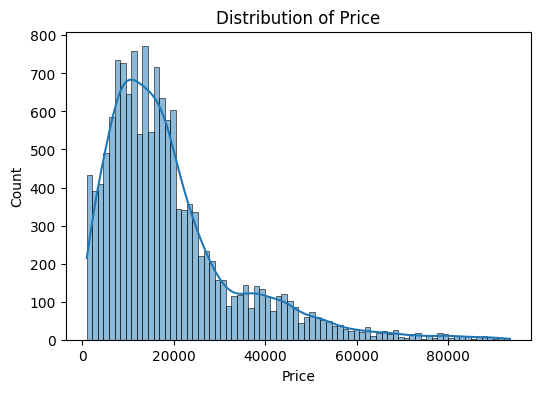

In [28]:
plt.figure(figsize=(6, 4))
sns.histplot(x=df_new['Price'], kde=True, fill=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


Now the distribution is still skewed but the values are realistic later we will scale these

### Univariate Analysis

In [29]:
df_new_cat = df_new[['Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel','Turbo','Cylinders','Airbags']]
df_new_num = df_new[['Price','Levy', 'carAge','Engine volume', 'Mileage']]

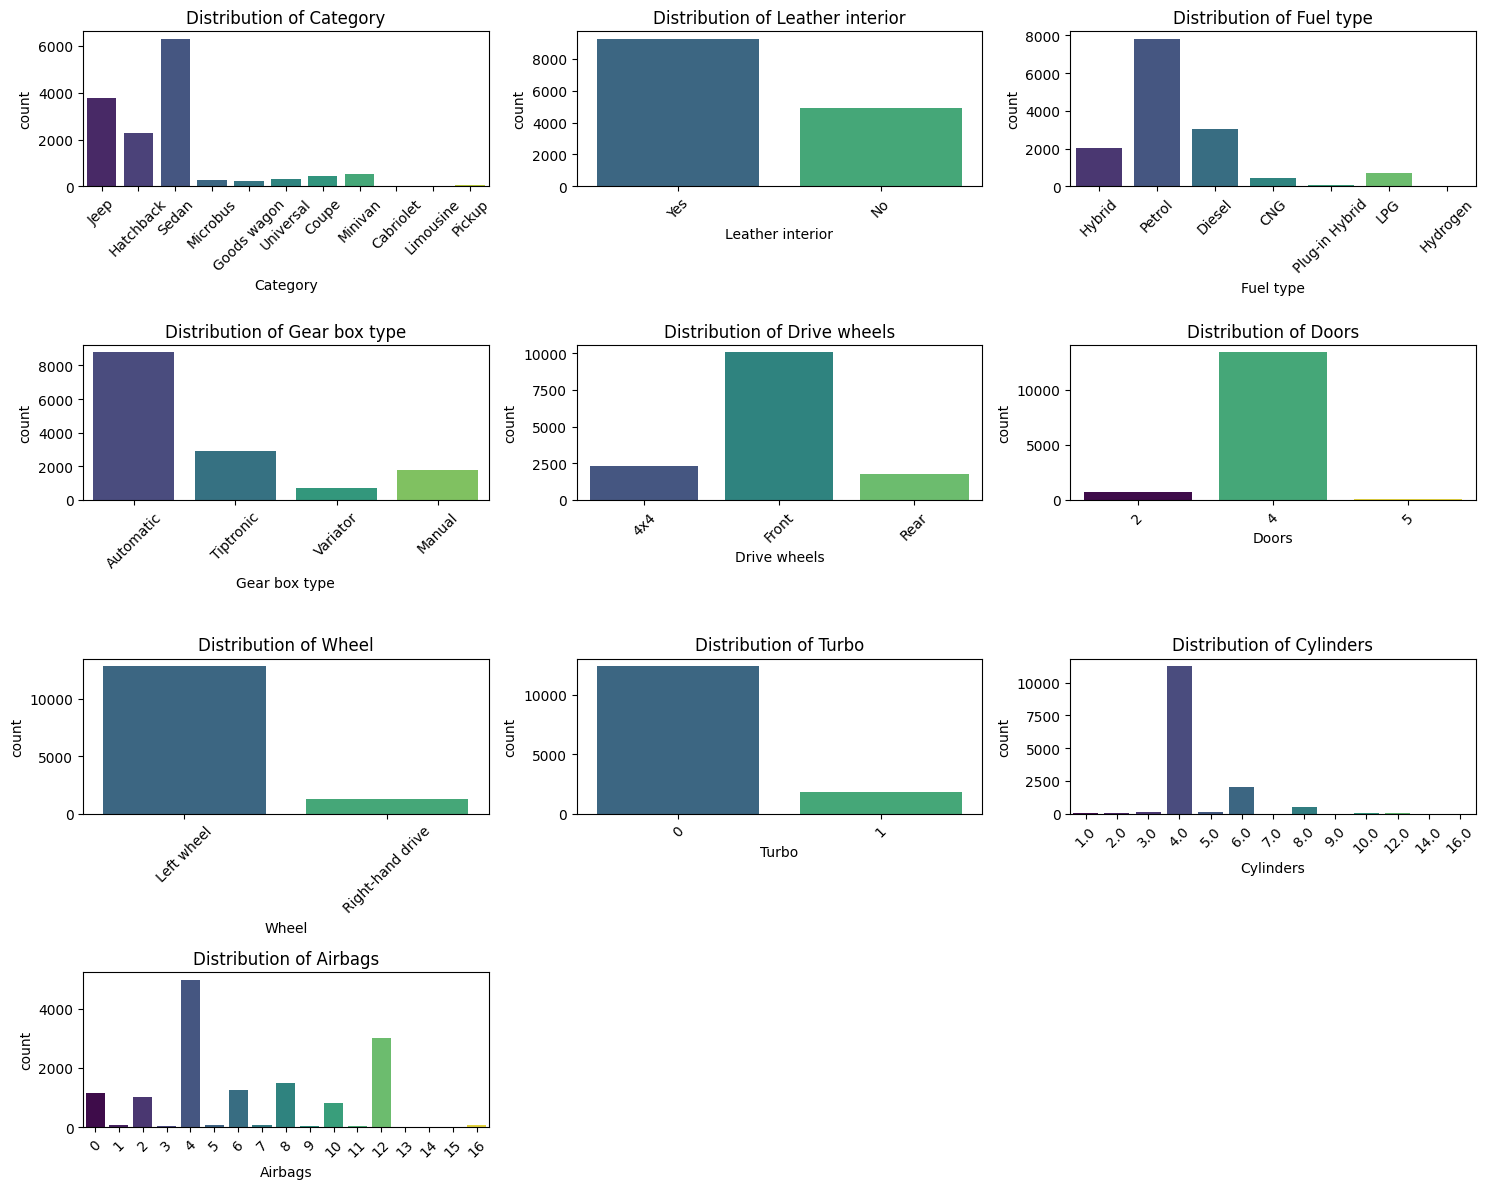

In [30]:
plt.figure(figsize=(15,12))
for i, col in enumerate(df_new_cat.columns,1):
  plt.subplot(4,3,i)
  sns.countplot(x=col, hue=col, legend=False, data=df_new, palette='viridis')
  plt.title(f'Distribution of {col}')
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

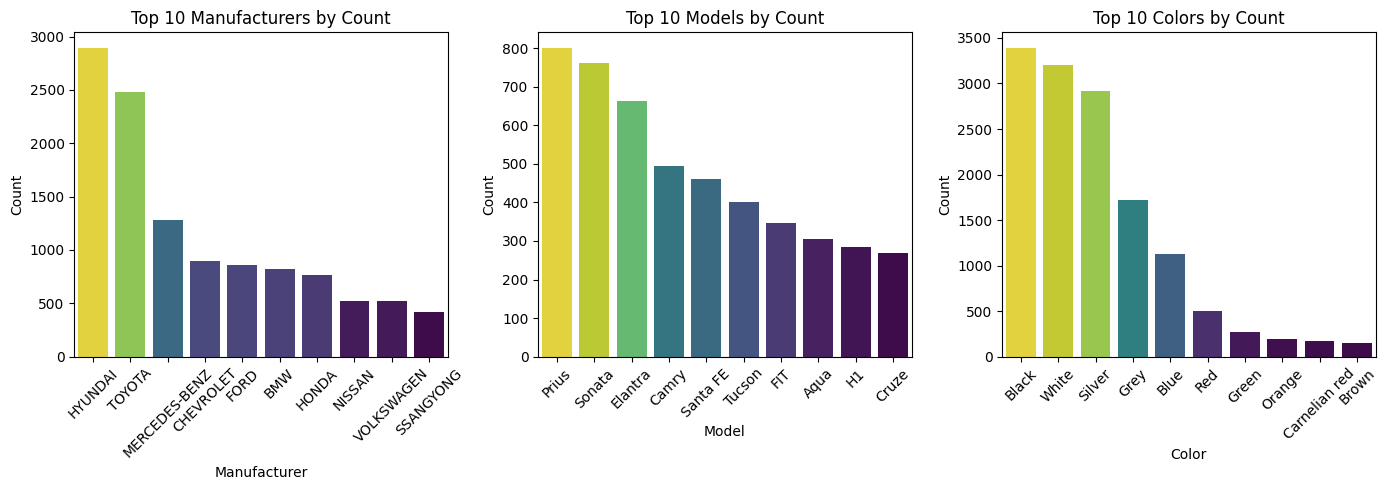

In [31]:
cols = ['Manufacturer', 'Model','Color']

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for i, col in enumerate(cols):
    top_vals = df_new[col].value_counts().nlargest(10)
    sns.barplot(y=top_vals.values,hue=top_vals.values, legend=False, x=top_vals.index, palette='viridis', ax=axes[i])
    axes[i].set_title(f"Top 10 {col}s by Count")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



There are lot of unique values in These categoircal features that's why we get the top 10 bcz all will looks too much messy

In [32]:
# plt.figure(figsize=(15,8))
# for i, col in enumerate(df_new_num.columns,1):
#   plt.subplot(3,3,i)
#   sns.histplot(df_new[col], fill=True, kde=True, color='purple')
#   plt.title(f'Distribution of {col}')

# plt.tight_layout()
# plt.show()

In Mileage there are many extremee values in bilions which is impossible

In cars, engine volume is usually 0.6L – 6.5L, but for trucks, buses, heavy vehicles it can go 10L, 15L, even 20L+

IN our data less engine volume is 0.0L which is unrealistic the min engine volume is 0.6 and max is 20L

In Mileage the min would be 0 and max can be 1000000+

### Bivariate Analysis

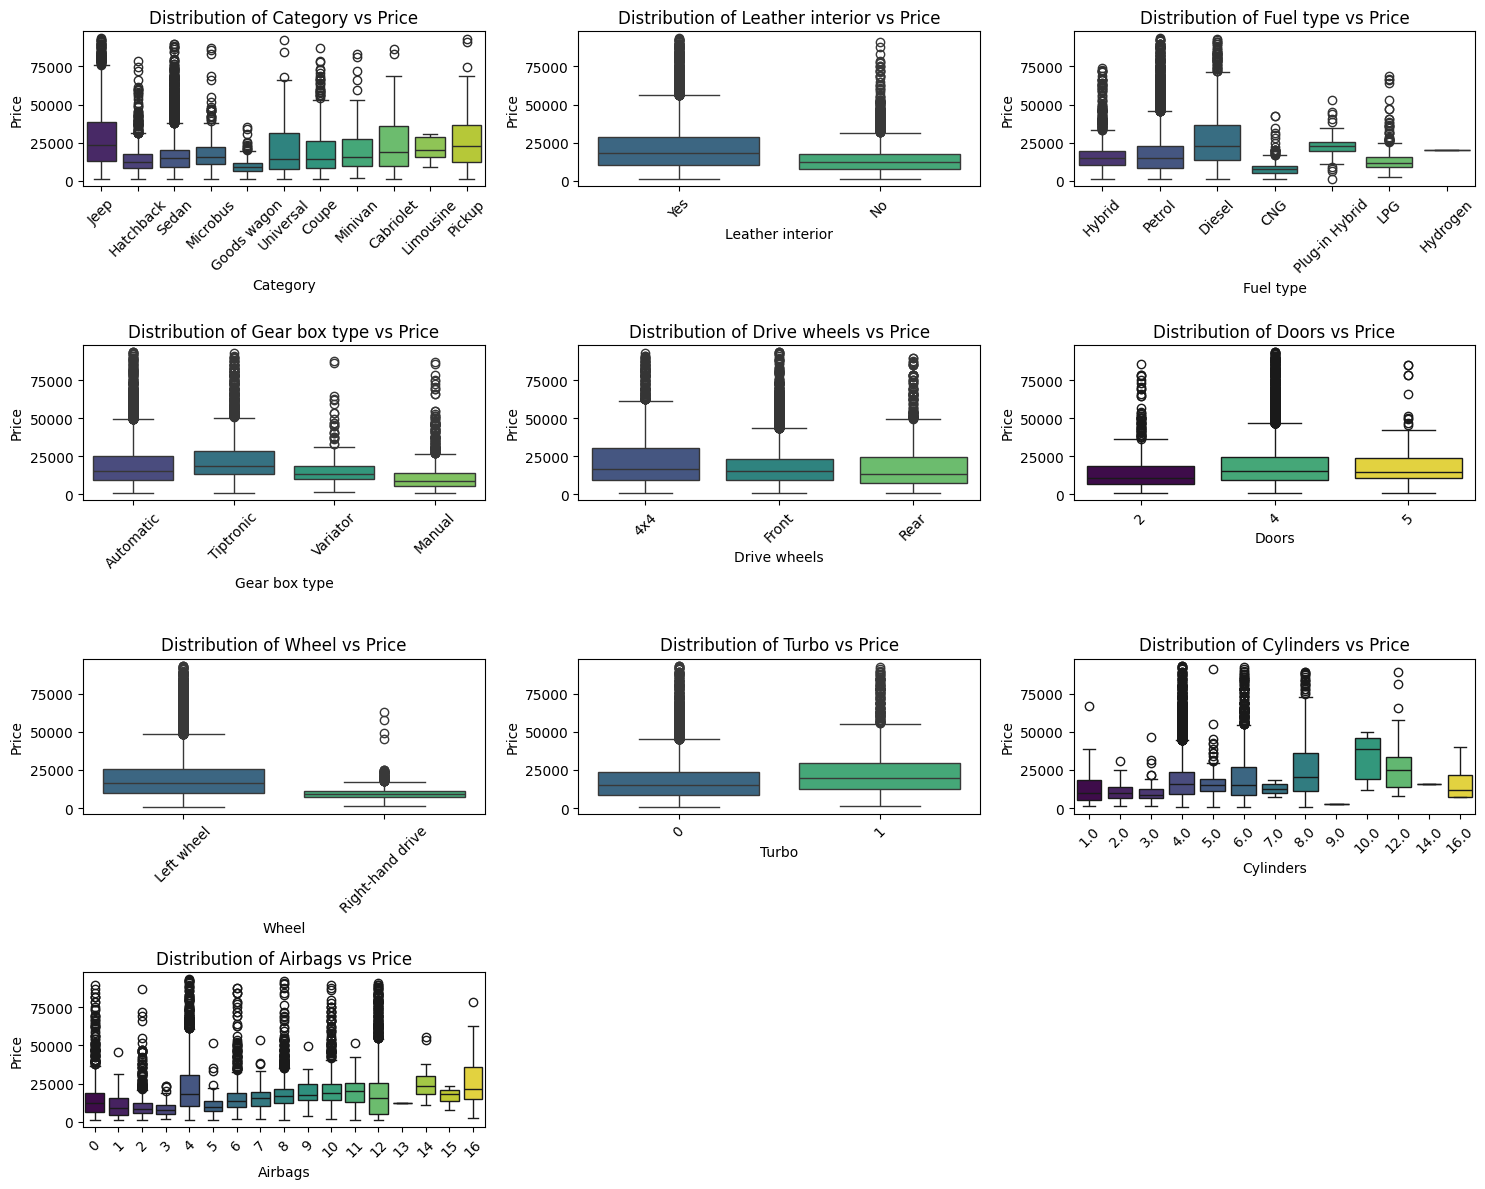

In [33]:
plt.figure(figsize=(15,12))
for i, col in enumerate(df_new_cat.columns,1):
  plt.subplot(4,3,i)
  sns.boxplot(x=col, y='Price', hue=col, legend=False, data=df_new, palette='viridis')
  plt.title(f'Distribution of {col} vs Price')
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

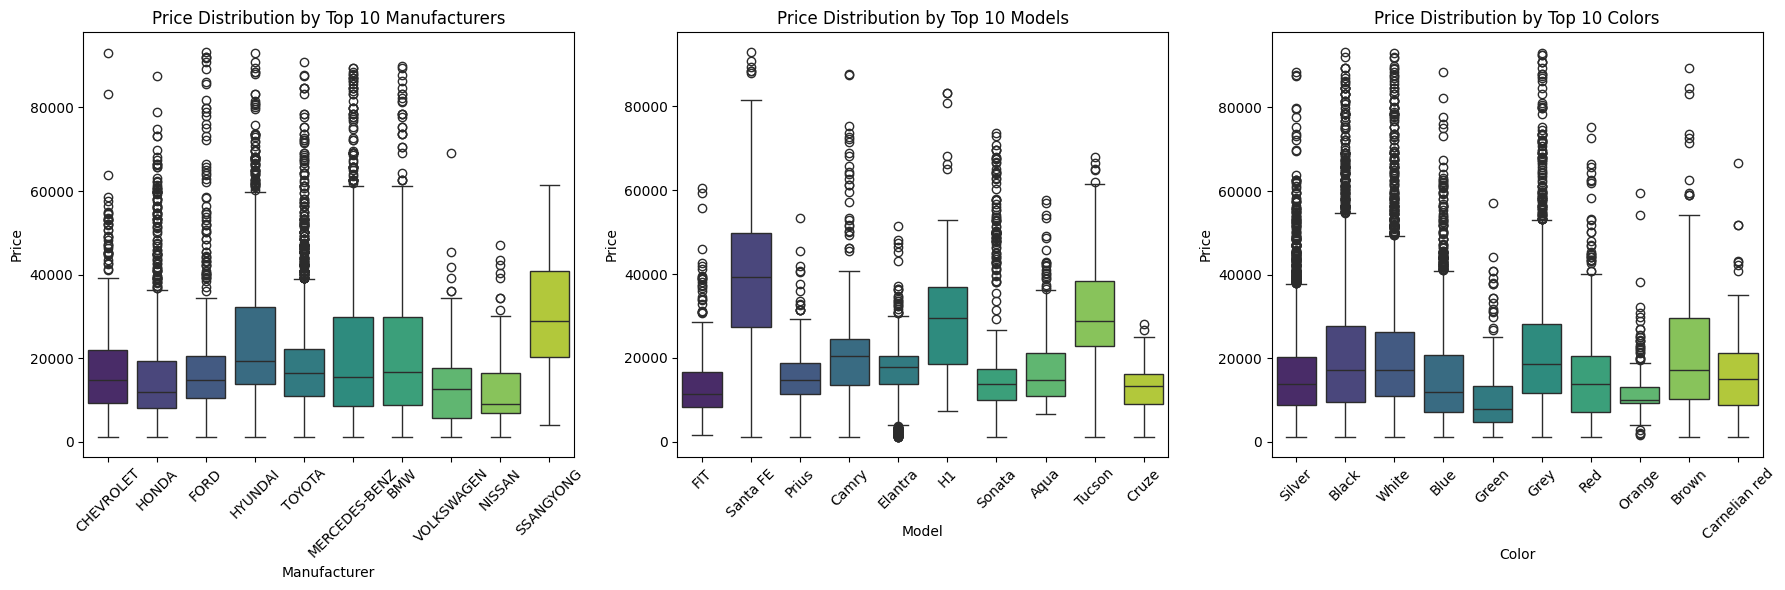

In [34]:
cols = ['Manufacturer', 'Model', 'Color']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(cols):
    top_vals = df_new[col].value_counts().nlargest(10).index
    df_top = df_new[df_new[col].isin(top_vals)]

    sns.boxplot(x=col,y='Price',hue=col,legend=False, data=df_top,palette='viridis',ax=axes[i])
    axes[i].set_title(f"Price Distribution by Top 10 {col}s")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Price")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



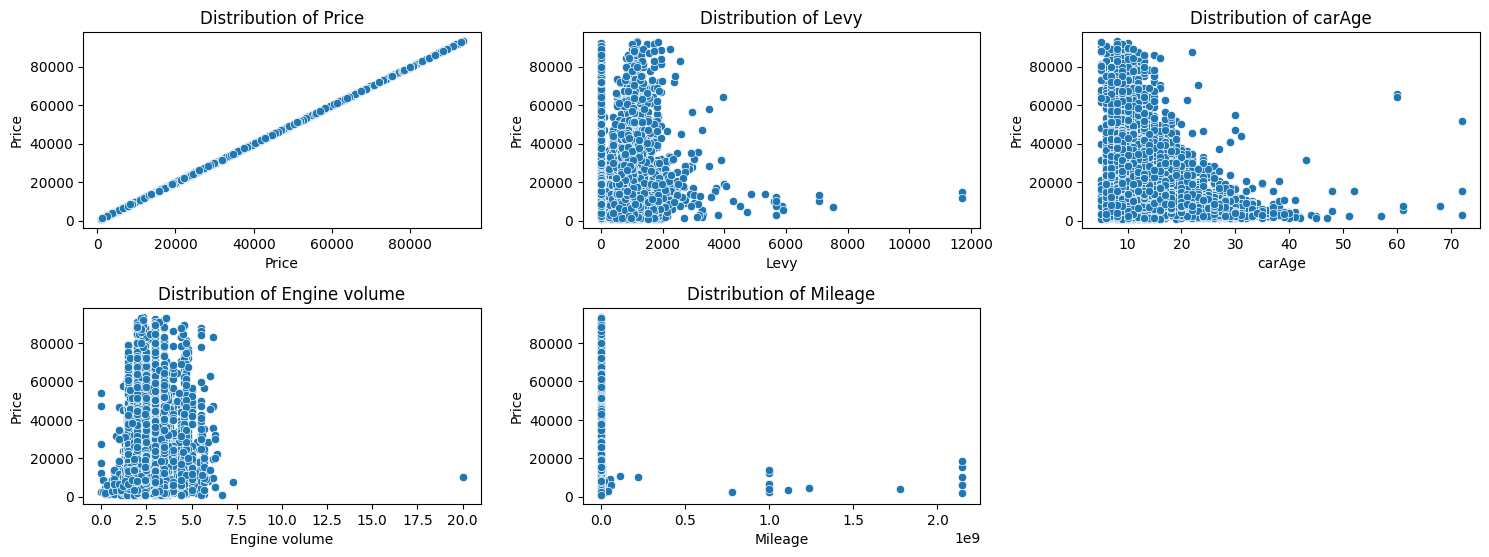

In [35]:
plt.figure(figsize=(15,8))
for i, col in enumerate(df_new_num.columns,1):
  plt.subplot(3,3,i)
  sns.scatterplot(x=col, y='Price', data=df_new_num)
  plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

### Fixing outliers or unrealistic values

In [36]:
df_new.shape

(14176, 18)

In [37]:
df_new = df_new[(df_new['Engine volume'] >= 0.6) & (df_new['Engine volume'] <= 20)]

In [38]:
df_new = df_new[(df_new['Mileage'] >= 0) & (df_new['Mileage'] <= 1_000_000)]


Better to drop inrealistic values it can be data entry mistake

it has very less amout so we drop it

## Spliting tha dataset

In [39]:
X = df_new.drop(columns='Price')
Y= df_new['Price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, shuffle=True, random_state=42)

## Feature Encoding

In [40]:
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

### Binary encoding

In [41]:
X_train_encoded['Leather interior'] = X_train_encoded['Leather interior'].map({'Yes':1, 'No':0})
X_train_encoded['Wheel'] = X_train_encoded['Wheel'].map({'Left wheel': 0, 'Right-hand drive': 1})

X_test_encoded['Leather interior'] = X_test_encoded['Leather interior'].map({'Yes':1, 'No':0})
X_test_encoded['Wheel'] = X_test_encoded['Wheel'].map({'Left wheel': 0, 'Right-hand drive': 1})


### One hot encoding
For nominal categorical features

In [42]:
X_train_ohe_cols = X_train_encoded[['Category', 'Fuel type', 'Gear box type', 'Drive wheels', 'Color']]
X_train_remaining_cols = X_train_encoded[['Leather interior', 'Wheel', 'Turbo','Cylinders','Airbags','Manufacturer','Model','Doors','Levy','carAge','Engine volume','Mileage']]

X_test_ohe_cols = X_test_encoded[['Category', 'Fuel type', 'Gear box type', 'Drive wheels', 'Color']]
X_test_remaining_cols = X_test_encoded[['Leather interior', 'Wheel', 'Turbo','Cylinders','Airbags','Manufacturer','Model','Doors','Levy','carAge','Engine volume','Mileage']]

In [43]:
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe_cols = pd.DataFrame(ohe.fit_transform(X_train_ohe_cols), columns=ohe.get_feature_names_out(X_train_ohe_cols.columns), index=X_train_ohe_cols.index)
X_test_ohe_cols = pd.DataFrame(ohe.transform(X_test_ohe_cols), columns=ohe.get_feature_names_out(X_test_ohe_cols.columns), index=X_test_ohe_cols.index)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [44]:
X_train_encoded = pd.concat([X_train_remaining_cols, X_train_ohe_cols], axis=1)
X_test_encoded = pd.concat([X_test_remaining_cols, X_test_ohe_cols], axis=1)

### Frequency encoding
For high cardinality features like model and manufacturer

In [45]:

high_card_cols = ['Manufacturer', 'Model']

for col in high_card_cols:

    freq_map = X_train_encoded[col].value_counts(normalize=True)

    X_train_encoded[col + '_freq'] = X_train_encoded[col].map(freq_map)
    X_test_encoded[col + '_freq'] = X_test_encoded[col].map(freq_map)

    X_train_encoded.drop(col, axis=1, inplace=True)
    X_test_encoded.drop(col, axis=1, inplace=True)
    X_test_encoded[col + '_freq'].fillna(0, inplace=True)


/tmp/ipython-input-2687535388.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test_encoded[col + '_freq'].fillna(0, inplace=True)
/tmp/ipython-input-2687535388.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [46]:
X_test_encoded.head()

,Leather interior,Wheel,Turbo,Cylinders,Airbags,Doors,Levy,carAge,Engine volume,Mileage,...,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow,Manufacturer_freq,Model_freq
2009,0,1,0,4.0,6,4,0,20,1.8,170000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.008755,0.000118
7211,1,0,0,4.0,4,4,730,9,1.6,107393,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.205040,0.003786
11207,1,0,0,6.0,12,4,1172,14,3.5,114000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.022007,0.002130
16706,1,0,0,4.0,4,4,1345,17,2.5,74367,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.029815,0.001656
939,1,0,0,4.0,12,4,394,11,2.5,77000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022007,0.001065


## Feature Scaling

In [47]:
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

In [48]:
num_cols = ['Levy','Mileage','Engine volume','carAge']

pt = PowerTransformer(method='yeo-johnson')
X_train_scaled[num_cols] = pt.fit_transform(X_train_scaled[num_cols])
X_test_scaled[num_cols] = pt.transform(X_test_scaled[num_cols])

scaler = StandardScaler()
X_train_scaled[num_cols] = scaler.fit_transform(X_train_scaled[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test_scaled[num_cols])


In [49]:
X_train_scaled.head()

,Leather interior,Wheel,Turbo,Cylinders,Airbags,Doors,Levy,carAge,Engine volume,Mileage,...,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow,Manufacturer_freq,Model_freq
5685,1,0,0,4.0,4,4,0.826945,-1.950713,-0.639675,-0.839925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.205040,0.028041
19178,0,0,0,4.0,6,4,-1.290878,1.660199,-0.430359,0.656878,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.037506,0.008637
16904,0,0,1,4.0,16,4,0.624386,-1.140276,-1.386044,-0.662411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062707,0.019167
18405,0,0,0,4.0,8,4,0.829467,-0.817026,0.666760,0.256209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059394,0.011832
6199,1,0,0,4.0,4,4,0.606581,-0.817026,-0.867088,-1.004383,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.205040,0.045315


## Model Building




In [50]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, Y_train)

RandomForestRegressor(random_state=42)

In [51]:
Y_pred = rf_model.predict(X_test_scaled)
score = r2_score(Y_pred, Y_test)
score

0.6578886608441723

In [52]:
gb_model = GradientBoostingRegressor(random_state=42, subsample=0.8,max_features='sqrt', n_estimators= 550, min_samples_split= 5, min_samples_leaf= 2, max_depth= 5, learning_rate= 0.05, n_iter_no_change=20, validation_fraction=0.2)
gb_model.fit(X_train_scaled, Y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, max_features='sqrt',
                          min_samples_leaf=2, min_samples_split=5,
                          n_estimators=550, n_iter_no_change=20,
                          random_state=42, subsample=0.8,
                          validation_fraction=0.2)

In [53]:
Y_pred = gb_model.predict(X_test_scaled)
score = r2_score(Y_pred, Y_test)
score

0.6244838609778144

In [54]:
xgb_model = xgb.XGBRegressor(
    n_estimators=500,          # number of trees
    learning_rate=0.05,        # step size shrinkage
    max_depth=5,               # depth of each tree
    min_child_weight=3,        # minimum sum of instance weight per leaf
    gamma=0,                   # minimum loss reduction to make a split
    subsample=0.8,             # fraction of samples per tree
    colsample_bytree=0.8,      # fraction of features per tree
    reg_alpha=0.01,            # L1 regularization
    reg_lambda=1,              # L2 regularization
    random_state=42,
    tree_method='auto',        # 'gpu_hist' if using GPU
    n_jobs=-1                  # use all CPU cores
)




xgb_model.fit(X_train_scaled, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [55]:
Y_pred = xgb_model.predict(X_test_scaled)
score = r2_score(Y_pred, Y_test)
score

0.689766526222229

## After Feature Selection

In [56]:
rf_importances = gb_model.feature_importances_
feat_importances = pd.DataFrame({
    "feature": X_train_scaled.columns,
    "importance": rf_importances
})

feat_importances = feat_importances.sort_values(by="importance", ascending=False)

threshold = 0.005   # 0.5%
selected_features = feat_importances[feat_importances["importance"] > threshold]["feature"].tolist()

print("Selected Features:", selected_features)

X_train_scaled = X_train_scaled[selected_features]
X_test_scaled = X_test_scaled[selected_features]


Selected Features: ['carAge', 'Engine volume', 'Mileage', 'Airbags', 'Category_Jeep', 'Levy', 'Manufacturer_freq', 'Model_freq', 'Gear box type_Tiptronic', 'Turbo', 'Leather interior', 'Fuel type_Diesel', 'Drive wheels_Front', 'Cylinders', 'Category_Sedan', 'Wheel', 'Gear box type_Manual', 'Fuel type_LPG', 'Fuel type_Hybrid', 'Fuel type_Petrol', 'Drive wheels_Rear']


In [57]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, Y_train)

RandomForestRegressor(random_state=42)

In [58]:
Y_pred = rf_model.predict(X_test_scaled)
score = r2_score(Y_pred, Y_test)
score

0.6664381608138625

In [59]:
gb_model = GradientBoostingRegressor(random_state=42, subsample=0.8,max_features='sqrt', n_estimators= 550, min_samples_split= 5, min_samples_leaf= 2, max_depth= 5, learning_rate= 0.05, n_iter_no_change=20, validation_fraction=0.2)
gb_model.fit(X_train_scaled, Y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, max_features='sqrt',
                          min_samples_leaf=2, min_samples_split=5,
                          n_estimators=550, n_iter_no_change=20,
                          random_state=42, subsample=0.8,
                          validation_fraction=0.2)

In [60]:
Y_pred = gb_model.predict(X_test_scaled)
score = r2_score(Y_pred, Y_test)
score

0.6614452888659441

In [61]:
xgb_model = xgb.XGBRegressor(
    n_estimators=500,          # number of trees
    learning_rate=0.05,        # step size shrinkage
    max_depth=5,               # depth of each tree
    min_child_weight=3,        # minimum sum of instance weight per leaf
    gamma=0,                   # minimum loss reduction to make a split
    subsample=0.8,             # fraction of samples per tree
    colsample_bytree=0.8,      # fraction of features per tree
    reg_alpha=0.01,            # L1 regularization
    reg_lambda=1,              # L2 regularization
    random_state=42,
    tree_method='auto',        # 'gpu_hist' if using GPU
    n_jobs=-1                  # use all CPU cores
)




xgb_model.fit(X_train_scaled, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [62]:
Y_pred = xgb_model.predict(X_test_scaled)
score = r2_score(Y_pred, Y_test)
score

0.6916447281837463

After feature selection the accuracy is Improved a bit.